In [132]:
##### Importando Bibliotecas: #####
import pandas as pd
import numpy as np
import itertools
import requests
import math
import os
import re
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from pydataset import data
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

initiated datasets repo at: C:\Users\Mariana Abrantes\.pydataset/


___
# Ciência dos Dados - PROJETO 3 - INSPER

___
### Mariana Abrantes, Gabriel Couto e Gabriel Miras
___

# Previsão de preços de smartphones ao dólar

___

## A. INTRODUÇÃO

Nestes últimos anos, com a instabilidade política e socioeconômica do Brasil, o preço do dólar está em constante variação. Consequentemente, os valores sobre produtos estrangeiros também mudam. Ao visualizar esse cenário, gostaríamos de analisar essa influência da alteração do valor do dólar sobre produtos da área tecnológica, em nosso caso smartphones. 

___
## B. MINERANDO DADOS e CARACTERÍSTICAS DO DATASET

__I) Preço do Dólar__ <br>
&emsp;O DataFrame foi obtido no [site](https://economia.uol.com.br/cotacoes/cambio/dolar-comercial-estados-unidos/) e foi filtrado da seguinte forma:
 * a) Definimos a coluna 'Data' como do tipo datetime e em seguida definimos essa coluna como índice da tabela
 * b) Pegamos apenas a coluna 'Compra' com o preço do dolar no dia e o índice das linhas
 * c) Definimos a coluna 'Compra' do tipo float e renomeamos ela pra "Dolar"

In [133]:
dolar = pd.read_table("dolar.csv", sep=";", usecols=['Data','Compra'])
dolar['Data'] = pd.to_datetime(dolar['Data'],  format='%d/%m/%Y %H:%M:%S')
dolar.index = dolar['Data']
dolar['Dolar'] = dolar['Compra'].astype('float')
dolar = dolar.loc[:,['Dolar']]

__II) Tabela de Preços dos Smartphones__ <br>
Os dados de cada celular foram retirados do histórico de preço médio do site buscape. <br>
* a) A função gerarBD() recebe uma lista com nome e url do celular para retornar um Dataframe de preço dos celulares e do dolar por dia.<br>
Para cada linha da lista:
    * 1) Cria uma cópia do Dataframe dolar chamado table
    * 2) Baixa o código da url fornecida e captura o ID do produto
    * 3) Com o ID baixamos o histórico de preço médio do aparelho em JSON e criamos o Dataframe bd com ele
    * 4) Usamos .join para unir as colunas num novo dataframe
    * 5) Definimos a coluna 'Data' como do tipo datetime e em seguida definimos essa coluna como índice da tabela<br>
* b) Removemos as linhas que possuam ao menos um valor vazio e retornamos essa nova tabela como resultado da função

In [134]:
#Recebe uma URL e retorna o código HTML da página (Só é chamada pela função baixarBD)
def baixarhtml(url):
    html = requests.get(url).text.splitlines()
    return html

#Recebe url do Buscape e retorna um Dataframe 
def gerarBD(lista):
    table = dolar.copy()
    
    for num in range(len(lista)):
        produto, url = lista[num][0], lista[num][1]
        
        #Pega ID do produto do buscape usando a url fornecida
        code = baixarhtml(url)
        for num_linha in range(len(code)):
            match = re.findall('"productId":[0-9]*', code[num_linha])
            if len(match)>0:
                id = match[0].split(':')[1]

        #Baixa BD dos preços
        code = baixarhtml("https://www.buscape.com.br/async/history/idu/" + id + "/days/365")

        #Pega só a parte dos dados e cria tabela bd
        bd = pd.read_json(code[0].split('"historicos":')[1][:-1])

        #Converte data pro formato e define essa coluna como índice
        bd['data'] = pd.to_datetime(bd['data'],  format='%d/%m/%Y')
        bd.set_index(bd['data'], inplace=True)
        
        #Adiciona a coluna com o nome do produto o preço do produto
        table[produto] = bd.loc[:,['precomed']]
        table[produto] = table[produto].astype(float)
    
    table = table.dropna(how='any') # Tira linha que tiver algum valor NaN
    return table

#Função retorno
def func_retorno(n,n_ant):
    val = 0
    if n_ant == 0:
        print('tem zero')
    else:
        val = math.log(n/n_ant)
    return val

In [135]:
links = [
    ['Iphone X',          "https://www.buscape.com.br/smartphone-apple-iphone-x-64gb"],
    ['Iphone 8 Plus',     "https://www.buscape.com.br/smartphone-apple-iphone-8-plus-64gb"],
    ['Iphone 7',          "https://www.buscape.com.br/smartphone-apple-iphone-7-32gb"],
    ['Iphone 7 Plus',     "https://www.buscape.com.br/smartphone-apple-iphone-7-plus-128gb"],
    ['Galaxy S8',         "https://www.buscape.com.br/smartphone-samsung-galaxy-s8-sm-g950-64gb"],
    ['Galaxy S8 Plus',    "https://www.buscape.com.br/smartphone-samsung-galaxy-s8-plus-sm-g955-128gb"],
    ['Galaxy S9',         "https://www.buscape.com.br/smartphone-samsung-galaxy-s9-sm-g960-128gb"],
    ['Galaxy S9 Plus',    "https://www.buscape.com.br/smartphone-samsung-galaxy-s9-plus-sm-g965-128gb"]
]

### BASE DE DADOS

Se não houver o arquivo tabela.csv criado executa a função gerarBD() e salva o dataframe como tabela.csv, se já houver o arquivo tabela.csv carrega ele como tabela

In [136]:
#Se já tiver um arquivo tabela.csv salvo carrega ele, se não cria a tabela e salva ela
exists = os.path.isfile('tabela.csv')
if exists:
    tabela = pd.read_csv('tabela.csv', sep=",")
    tabela.index = tabela['data']
    tabela = tabela.loc[:,list(tabela.columns)[1:]]
else:
    tabela = gerarBD(links)
    tabela.to_csv('tabela.csv')

In [137]:
tabela.head()

,Iphone X,Iphone 8 Plus,Iphone 7,Iphone 7 Plus,Galaxy S8,Galaxy S8 Plus,Galaxy S9,Galaxy S9 Plus,Dolar
data,,,,,,,,,
2018-05-22,5791.4575,4019.5854,3033.4468,3491.2202,3050.4950,4085.785,3956.2925,4479.7305,3.6447
2018-05-23,5853.7800,4057.0140,3043.2737,3406.8965,3061.1514,3672.570,3966.1755,4490.3880,3.6251
2018-05-24,5885.4900,3896.7625,2852.5547,3444.2380,2992.7668,4028.438,3966.7402,4502.2856,3.6483
2018-05-25,5876.5710,4019.7207,2985.7068,3470.2570,3130.3193,3685.785,4007.9338,4469.3877,3.6683
2018-05-28,5907.1025,3886.1116,2995.6414,3488.4626,3062.2104,4028.438,3995.7700,4526.9487,3.7286


__III) Criando tabela de retorno__

In [138]:
df = tabela.copy()

#Cria coluna com o valor da linha anterior
for coluna in tabela.columns:
    df[coluna+'-1'] = df[coluna].shift(1)

df = df.iloc[1:,:] # Tira primeira linha (perdida pra fazer deltas)

dic={}
for coluna in tabela.columns:
    lis,ind=[],[]
    for index, row in df.iterrows():
        retor = func_retorno(row[coluna],row[coluna+'-1'])
        lis.append(retor)
        ind.append(index)
    dic[coluna]=lis

retorno = pd.DataFrame(data=dic,index=ind)

In [139]:
retorno.head()

,Iphone X,Iphone 8 Plus,Iphone 7,Iphone 7 Plus,Galaxy S8,Galaxy S8 Plus,Galaxy S9,Galaxy S9 Plus,Dolar
2018-05-23,0.010704,0.009268,0.003234,-0.024450,0.003487,-0.106622,0.002495,0.002376,-0.005392
2018-05-24,0.005402,-0.040301,-0.064719,0.010901,-0.022593,0.092487,0.000142,0.002646,0.006379
2018-05-25,-0.001517,0.031066,0.045622,0.007526,0.044937,-0.088895,0.010331,-0.007334,0.005467
2018-05-28,0.005182,-0.033803,0.003322,0.005232,-0.021998,0.088895,-0.003040,0.012797,0.016304
2018-05-29,0.009240,0.016236,-0.037699,0.005742,0.020046,0.011541,0.001311,0.007073,0.002839


### ANÁLISE DESCRITIVA

Em nossa base de dados buscamos os preços de telefones das marcas Apple e Samsung, sendo eles Iphone X, Iphone 8 Plus, Iphone 7 plus, iphone 7, Galaxy S8, Galaxy S8 Plus, Galaxy S9 e Galaxy S9 Plus. Além disso, pegamos também as características dos modelos escolhidos para que nossa análise seja mais específica, pois ao mudar o tamanho da memória do celular, por exemplo, o preço se altera também. Desse modo, conseguiremos analisar qual a interferência da alteração do dólar nos valores dos smartphones. 

In [140]:
retorno.corr()['Dolar']

Iphone X         -0.000626
Iphone 8 Plus    -0.014322
Iphone 7         -0.045196
Iphone 7 Plus     0.079599
Galaxy S8        -0.078579
Galaxy S8 Plus   -0.039319
Galaxy S9         0.049093
Galaxy S9 Plus    0.032512
Dolar             1.000000
Name: Dolar, dtype: float64

# Descriçao analise

___
## C. MODELOS DE PREDIÇÃO

O MODELO DE PREDIÇÃO PELA MÉDIA (Sem uso de variável explicativa).

In [141]:
medias = []
for i in tabela.columns:
    facil = tabela.loc[:, ['Dolar', i]]
    for a in facil[i]:
        valores = facil[i].mean()
    medias.append(valores)
    
#print(medias)        
#facil = tabela.loc[:, ['Dolar', 'Iphone 7']]

In [142]:
resultados=[] 
for i in tabela.columns[:-1]:
    xc = sm.add_constant(tabela['Dolar'])
    model = sm.OLS(tabela[i], xc)
    results = model.fit()
    resultados.append(results.summary())

resultados[1]
#xc = sm.add_constant(facil['Dolar'])
#model = sm.OLS(facil['Iphone 7'],xc)
#results = model.fit()
#results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Iphone 8 Plus   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.697
Date:                Thu, 23 May 2019   Prob (F-statistic):             0.0557
Time:                        17:24:51   Log-Likelihood:                -1704.3
No. Observations:                 245   AIC:                             3413.
Df Residuals:                     243   BIC:                             3420.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5081.8608    489.586     10.380      0.000    4117.487    6046.235
Dolar       -244.5555    127.196     -1.923      0.056    -495.103       5.992
==============================================================================
Omnibus:                        1.380   Durbin-Watson:                   0.364
Prob(Omnibus):                  0.502   Jarque-Bera (JB):                1.419
Skew:                          -0.178   Prob(JB):                        0.492
Kurtosis:                       2.891   Cond. No.                         123.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

o MODELO DOS K VIZINHOS MAIS PRÓXIMOS (K-Nearest Neighbors Regression)

In [159]:
X=tabela['Dolar']
y=tabela.loc[:,['Iphone 7','Iphone 7 Plus','Iphone X', 'Iphone 8 Plus', 'Galaxy S8', 'Galaxy S8 Plus', 'Galaxy S9', 'Galaxy S9 Plus']]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.3,random_state=0)

In [176]:
clf=KNeighborsRegressor(1)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print(mean_squared_error(y_test,y_pred))

ValueError: Expected 2D array, got 1D array instead:
array=[3.7053 3.9147 3.7361 3.7307 4.1044 3.8773 3.8001 3.6728 3.824  3.8448
 3.7267 3.6683 3.7203 3.8755 3.9344 3.857  3.9052 3.864  3.7156 3.7395
 3.7443 3.7531 3.8575 3.7658 3.8418 4.1667 3.7071 3.7894 3.7655 3.8688
 4.088  3.8384 3.9207 3.9298 3.8751 3.7739 3.7075 3.9111 3.7566 3.9018
 3.7633 3.8206 3.7179 3.7892 3.9758 3.8748 3.6588 3.9577 3.8682 3.7253
 3.6483 3.9007 3.8757 3.9561 3.7431 3.9154 3.7342 3.7155 3.7227 3.7629
 3.7635 3.7343 3.8876 3.8521 3.958  3.6943 3.6447 3.896  3.857  4.1143
 3.7589 3.7548 4.0477 4.0366 3.9046 3.798  3.9227 3.9013 4.1455 3.7342
 3.8558 3.8787 4.1019 3.7367 4.1414 4.0717 3.7822 3.9317 3.8133 3.8575
 3.7661 3.7412 4.0183 3.9174 3.9258 3.7567 3.6822 3.8841 3.8973 3.7225
 4.123  3.6251 3.8313 3.9792 3.7831 3.6872 3.8423 3.8569 3.73   3.846
 3.8592 3.7671 3.7587 3.7434 3.8767 3.8811 3.8954 3.7324 3.7273 3.7559
 3.8096 3.8687 3.7916 3.9175 3.728  3.8542 3.9863 3.8647 3.7719 3.8945
 3.9022 3.9215 3.913  3.734  3.7788 4.1422 3.9962 3.7065 4.1957 3.8165
 3.9545 3.7583 3.8942 3.9536 4.152  4.1542 3.8557 3.8057 4.1252 3.942
 3.6664 3.9392 3.8415 3.8358 3.8669 3.8802 4.0262 3.8491 4.1463 4.083
 3.8508 3.7831 3.8763 3.81   3.725  3.8702 4.0812 3.7803 3.7382 3.73
 3.6622].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

o MODELO DE REGRESSÃO LINEAR (Multiple Linear Regression)

In [206]:
x = retorno['Dolar']
xb = x.mean()
x_v = np.linspace(x.min(), x.max(), 500)


def Regressao():
    betas = []
    valoresY = []
    
    for i in retorno.columns[:-1]:
        y = retorno[i]

        #beta^0 e beta^1
        yb = y.mean()


        Sxy = ((x -xb)*(y -yb)).sum()
        Sxx = ((x -xb)**2).sum()

        b1 = Sxy/Sxx
        b0 = yb - b1*xb
        betas.append([b0, b1])
        
        y_v = b0 + b1*x_v
        valoresY.append(y_v)
        
    return [betas, valoresY]
    
#print(Regressao()[0]) ---> valores beta
#len(Regressao()[1]) #---> valores Y

ValueError: x and y must be the same size

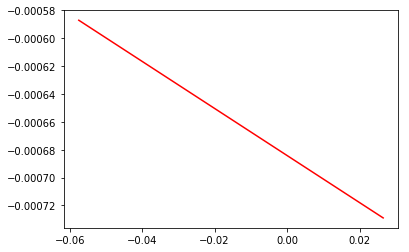

In [207]:
valoresY = Regressao()[1]
for i in range(len(retorno.columns[:-1])):
    plt.plot(x_v,valoresY[i], color="r") # resultados da regressão
    plt.scatter(x, y); # dados
    plt.xlabel("x: dolar");
    plt.ylabel("y: celular");
    plt.show() #informar os nomes de celular em cada grafico

In [210]:
e = y - (b0 + b1*x) # Escreva sua fórmula dos resíduos aqui

stats.probplot(e, dist='norm', plot=plt); # Verifique graficamente  se é uma normal - como fazer isso?

ValueError: all the input array dimensions except for the concatenation axis must match exactly

o MODELO DE ÁRVORES DE REGRESSÃO (Decision Tree Regression)

___
## D. PROCESSO E ESTATÍSTICAS DE VALIDAÇÃO

[Esse item depende dos resultados das modelagens anteriores! Organize-os aqui de forma clara!]

___
## E. CONCLUSÃO

___
## F. REFERÊNCIAS BIBLIOGRÁFICAS

https://br.investing.com/ $\rightarrow$ site para busca da cotação dos dolores
_________
https://www.buscape.com.br $\rightarrow$ site para busca de histórico dos preços